
# Multi-bit leakage modelling

Fitting multi-bit models for the leakage of the AES S-box output. 

The first model is of the form
$$\beta_0x_0 + \beta_1x_1 + \ldots + \beta_7x_7 + \beta_{const}$$

where $x_i$ is bit $i$ of byte $x$, and 9 coefficients $\beta_i$ and $\beta_{const}$ are to be estimated
with linear regression using ordinary least squares. $\beta_{const}$ is the intercept and will not be used later (correlation is invariant to it).

Other models are:
* 2-component model (a reduced 8-component model with only 2 LSB's considered)
* Hamming weight model, i.e. with only one basis function $g_0 = \text{HW}(x)$
* 256-component model with all possible products of the 8 bits

Observe how the resulting coefficients match the single-bit model from the previous example in the sense
of the contribution of each bit to the model.

Results in terms of the adjusted coefficient of determination $\bar R^2$:
* HW model: 0.328
* 9-component model: 0.435
* 2-component model: 0.324
* 256-component model: 0.437

Part of the leakage modeling tutorial, license is GPLv3, see https://www.gnu.org/licenses/gpl-3.0.en.html<br>
Requires traces and data from [pysca toolbox](https://github.com/ikizhvatov/pysca)

In [1]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

/Users/ilya/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


The functions in the next cell do 2 things in the same place:
1. define basis functions $g_i(x)$ of a leakage model for a byte $x$:
    $$\beta_0g_0(x) + \beta_1g_1(x) + \ldots + \beta_ng_n(x)$$
1. compute and return the values of $g_i(x)$ such that they can be used later to obtain rows of the matrix for linear regression

In [2]:
# A simple 9-component linear model (sum of bits with different
#  coefficients): gi = xi, 0 <= i < 8.
def leakageModel9(x):
    g = []
    for i in range(0, 8):
        bit = (x >> i) & 1  # this is the definition: gi = [bit i of x]
        g.append(bit)
    return g
# same but only two LSB's included (because teh above shows that they are the
#  most contributing ones)
def leakageModel2(x):
    g = []
    for i in range(0, 2):
        bit = (x >> i) & 1
        g.append(bit)
    return g

# A Hamming weight model: g0 = HW(x)
def leakageModelHW(x):
    g = []
    hw = byteHammingWeight[x]  # this is the definition: gi = HW(x)
    g.append(hw)
    return g

# An 'all 256 bit combinations' model:
# a) helper from http://wiki.python.org/moin/BitManipulation
def parityOf(int_type):
    parity = 0
    while (int_type):
        parity = ~parity
        int_type = int_type & (int_type - 1)
    if (parity != 0): # to convert -1 to 1
        parity = 1
    return(parity)
# b) the model itself
def leakageModel256(x):
    g = []
    # note that we start from 1 to exclude case 0 which means the function
    # does not depend on any bit of x, i.e. a constant - we will add the
    # constant explicitly later as the last column.
    for i in np.arange(1, 256, dtype='uint8'):
        xmasked = x & i
        gi = parityOf(xmasked)
        g.append(gi)
    return g

Load AES S-box and the table for getting the Hamming weight of a byte

In [3]:
sbox = np.load('../data/aessbox.npy')
byteHammingWeight = np.load('../data/bytehammingweight.npy')

Load samples and data

In [4]:
inputRange = range(0, 1000) # range for traces (not samples!)
SboxNum = 0
SampleNum = 1025

npzfile = np.load('../traces/swaes_atmega_power.npz')
data = npzfile['data'][inputRange,SboxNum]
traces = npzfile['traces'][inputRange,SampleNum]

Now, knowing the key byte, we compute the intermediate variable values: S-box outputs

In [5]:
key = b'\x2b\x7e\x15\x16\x28\xae\xd2\xa6\xab\xf7\x15\x88\x09\xcf\x4f\x3c'
keyByte = np.uint8(key[SboxNum])
sBoxOut = sbox[data ^ keyByte]

Build the system of equations and solve it using OLS. Notice now there are several coefficients and a constant in the results.

leakageModel9 can be replace to any other basis function set, e.g. leakageModel256, for comparison.

In [6]:
X = map(leakageModel9, sBoxOut)             # left-hand part of the system
A = sm.add_constant(list(X), prepend=False) # add constant coefficient (trailing column of ones)
results = sm.OLS(traces, A).fit()           # the OLS itself
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     99.89
Date:                Thu, 28 Sep 2017   Prob (F-statistic):          1.03e-121
Time:                        17:03:53   Log-Likelihood:                -3200.1
No. Observations:                1000   AIC:                             6418.
Df Residuals:                     991   BIC:                             6462.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             5.9166      0.378     15.652      0.0

Save the model (do not forget to rename the file later!)

In [7]:
np.save('results/lrmodel', results.params)

Plot the coefficients except for the intercept

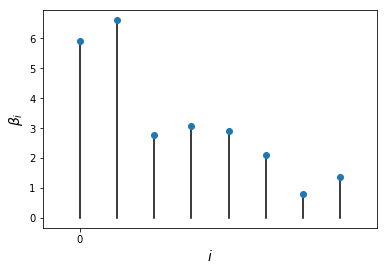

In [8]:
for i in range(len(results.params) - 1):
    line = np.array([0, results.params[i]])
    plt.plot(np.array([i, i]), line, '-', color='black')
plt.plot(results.params[0:-1], 'o')
plt.xlabel(r'$i$', fontsize=14)
plt.ylabel(r'$\beta_i$', fontsize=14)
plt.xlim(-1, A.shape[1]-1)
plt.xticks(np.arange(0, len(results.params) - 1, 32))
plt.show()